<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/11_CNN_Visualization_GradCAM_GradCAM%2B%2B_and_FasterScoreCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 901.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    F

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 28s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**Load Test Images**

In [ ]:
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/bear.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/soldiers.jpg

--2023-08-07 02:59:12--  https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg [following]
--2023-08-07 02:59:12--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg.1’

goldfish.jpg.1      100%[===================>]   8.63K  --.-KB/s    in 0s      

2023-08-07 02:59:12 (95.5 MB/s) - ‘goldfish.jpg.1’ saved [8833/88

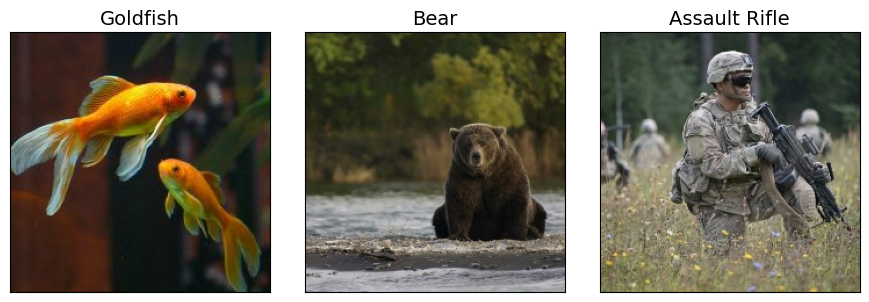

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

image_titles = ['Goldfish', 'Bear', 'Assault Rifle']

img1 = load_img('goldfish.jpg', target_size=(224,224))
img2 = load_img('bear.jpg', target_size=(224,224))
img3 = load_img('soldiers.jpg', target_size=(224,224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

X = preprocess_input(images)

subplot_args = {'nrows':1, 'ncols':3, 'figsize':(9,3),
                'subplot_kw':{'xticks':[], 'yticks':[]}}

f, ax = plt.subplots(**subplot_args)

for i, title in enumerate(image_titles):
  ax[i].set_title(title, fontsize=14)
  ax[i].imshow(images[i])

plt.tight_layout()
plt.show()

In [ ]:
def loss(output):
  return (output[0][1], output[1][294], output[2][413])

In [ ]:
def model_modifier(m):
  m.layers[-1].activation = tf.keras.activations.linear

**GradCAM**

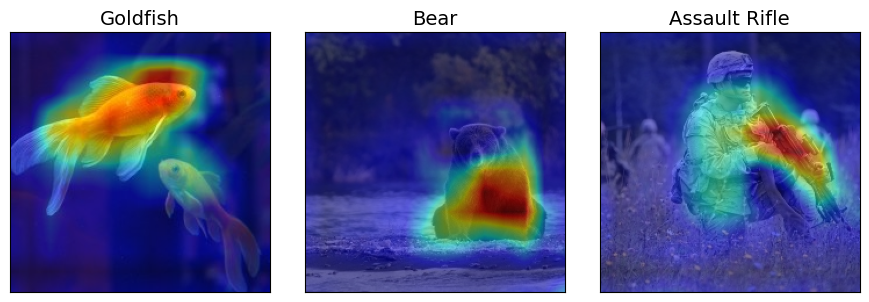

CPU times: user 659 ms, sys: 98.7 ms, total: 758 ms
Wall time: 787 ms


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Generate gradcam object
gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)

# Generate heatmap
cam = gradcam(loss, X, penultimate_layer=-1, #model.layers number
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
  heatmap = np.uint8(cm.jet(cam[i])[...,:3]*255)
  ax[i].set_title(title, fontsize=14)
  ax[i].imshow(images[i])
  ax[i].imshow(heatmap, cmap='jet', alpha=0.5) #overlay
plt.tight_layout()
plt.show()

**Gradcam++**

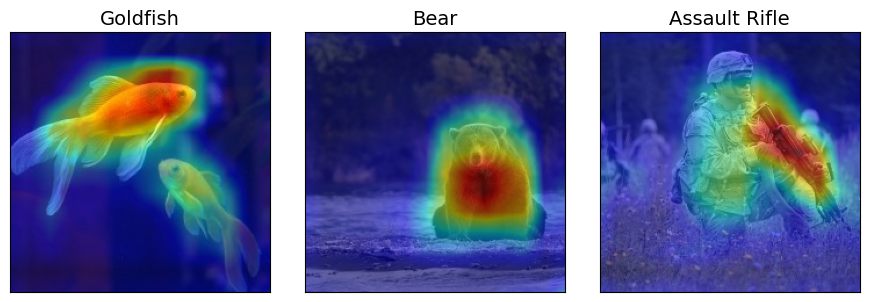

CPU times: user 664 ms, sys: 95.8 ms, total: 760 ms
Wall time: 774 ms


In [ ]:
%%time
from tf_keras_vis.gradcam import GradcamPlusPlus

# Generate gradcam object
gradcam = GradcamPlusPlus(model, model_modifier=model_modifier, clone=False)

# Generate heatmap
cam = gradcam(loss, X, penultimate_layer=-1, #model.layers number
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
  heatmap = np.uint8(cm.jet(cam[i])[...,:3]*255)
  ax[i].set_title(title, fontsize=14)
  ax[i].imshow(images[i])
  ax[i].imshow(heatmap, cmap='jet', alpha=0.5) #overlay
plt.tight_layout()
plt.show()


**ScoreCAM**

48/48 [==============================] - 10s 104ms/step


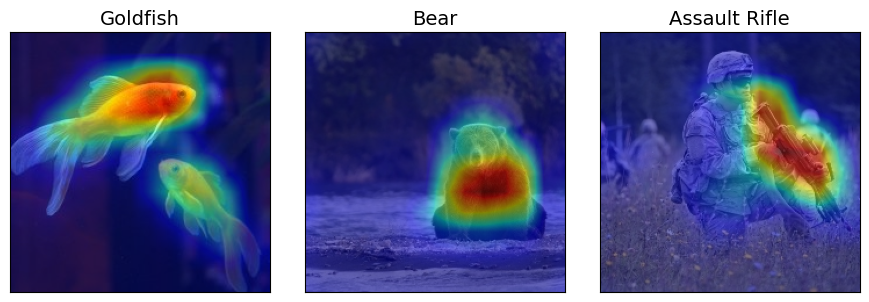

CPU times: user 27 s, sys: 5.54 s, total: 32.5 s
Wall time: 36.7 s


In [ ]:
%%time
from tf_keras_vis.scorecam import ScoreCAM

# Generate gradcam object
scorecam = ScoreCAM(model, model_modifier=model_modifier, clone=False)

if gpus > 0:
  # Generate heatmap
  cam = scorecam(loss, X, penultimate_layer=-1, #model.layers number
                )
  cam = normalize(cam)

  f, ax = plt.subplots(**subplot_args)
  for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[...,:3]*255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) #overlay
  plt.tight_layout()
  plt.show()
else:
  print('NOTE: Change to GPU to see the visual')

**Faster ScoreCAM**

3/3 [==============================] - 4s 2s/step


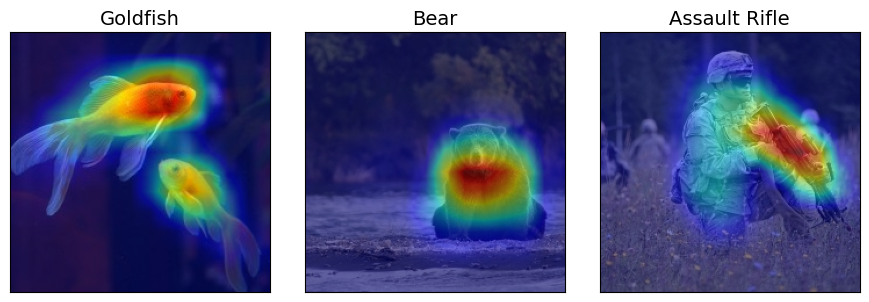

CPU times: user 5.53 s, sys: 407 ms, total: 5.93 s
Wall time: 7.81 s


In [ ]:
%%time
from tf_keras_vis.scorecam import ScoreCAM

# Generate gradcam object
scorecam = ScoreCAM(model, model_modifier=model_modifier, clone=False)


# Generate heatmap
cam = scorecam(loss, X, penultimate_layer=-1, #model.layers number
                max_N=10)
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
  heatmap = np.uint8(cm.jet(cam[i])[...,:3]*255)
  ax[i].set_title(title, fontsize=14)
  ax[i].imshow(images[i])
  ax[i].imshow(heatmap, cmap='jet', alpha=0.5) #overlay
plt.tight_layout()
plt.show()